# 데이터분석캡스톤디자인
## 데이터 시각화 + 시계열 예측 분석

In [1]:
#기본 모듈 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# 한글 시각화
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

## 1. 데이터 확인 

In [3]:
# 18년부터 21년까지의 역별 실적 csv 파일 읽기
df_station18 = pd.read_csv('역별 승하차실적_2018.csv', parse_dates=["운행일자"])
df_station19 = pd.read_csv('역별 승하차실적_2019.csv', parse_dates=["운행일자"])
df_station20 = pd.read_csv('역별 승하차실적_2020.csv', parse_dates=["운행일자"])
df_station21 = pd.read_csv('역별 승하차실적_2021.csv', parse_dates=["운행일자"])

In [4]:
# 18년부터 21년까지의 역별 실적 데이터 합치기
df_station = pd.concat([df_station18, df_station19, df_station20, df_station21], ignore_index=True)
df_station.tail()

운행일자 운행영업일단계 주운행선 상행하행구분   역무열차종  정차역  메트릭 승차인원수 하차인원수
1900117  2021년 05월 31일      평일  강릉선     상행  KTX-호남  서원주  NaN    19    16
1900118  2021년 05월 31일      평일  강릉선     상행  KTX-호남   횡성  NaN   191    32
1900119  2021년 05월 31일      평일  강릉선     상행  KTX-호남   둔내  NaN   124     6
1900120  2021년 05월 31일      평일  강릉선     상행  KTX-호남   평창  NaN   152    25
1900121  2021년 05월 31일      평일  강릉선     상행  KTX-호남   진부  NaN   236    21

In [5]:
# 데이터프레임 상태 확인
df_station.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900122 entries, 0 to 1900121
Data columns (total 9 columns):
 #   Column   Dtype  
---  ------   -----  
 0   운행일자     object 
 1   운행영업일단계  object 
 2   주운행선     object 
 3   상행하행구분   object 
 4   역무열차종    object 
 5   정차역      object 
 6   메트릭      float64
 7   승차인원수    object 
 8   하차인원수    object 
dtypes: float64(1), object(8)
memory usage: 130.5+ MB


## 2. 데이터 전처리

In [6]:
#역 데이터 결측치 확인
df_station.isnull().sum()

운행일자             0
운행영업일단계          0
주운행선             0
상행하행구분           0
역무열차종            0
정차역              0
메트릭        1900122
승차인원수            0
하차인원수            0
dtype: int64

- 메트릭 컬럼의 값들은 모두 결측치인 것으로 확인 가능

In [7]:
#메트릭 컬럼 제거
df_station.dropna(axis='columns', inplace=True)
df_station.head()

운행일자 운행영업일단계 주운행선 상행하행구분 역무열차종  정차역   승차인원수  하차인원수
0  2018년 01월 01일     공휴일  경부선     하행   KTX   서울  20,699     90
1  2018년 01월 01일     공휴일  경부선     하행   KTX   용산   1,907      0
2  2018년 01월 01일     공휴일  경부선     하행   KTX  영등포     173      0
3  2018년 01월 01일     공휴일  경부선     하행   KTX   수원   1,674     44
4  2018년 01월 01일     공휴일  경부선     하행   KTX   대전   3,015  5,302

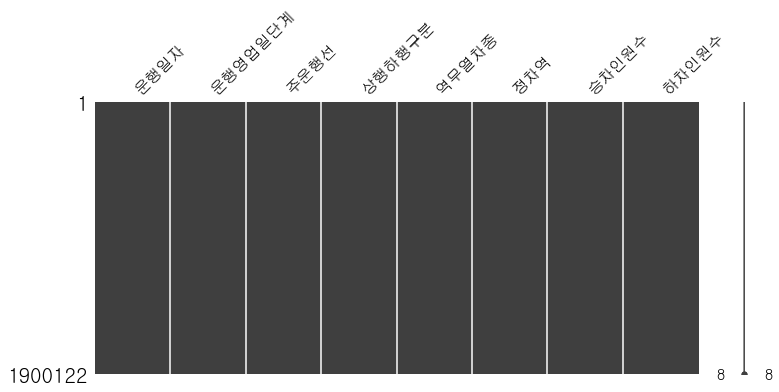

In [8]:
# 결측치 시각화
import missingno as msno

msno.matrix(df_station, figsize=(12,5))

- 메트릭 컬럼 제거 이후 역별 실적 데이터에 결측치가 존재하지 않음을 확인할 수 있다.

In [9]:
#승차인원수, 하차인원수 컬럼을 int type으로 바꾸기 위해 콤마 제거
df_station['승차인원수'] = df_station['승차인원수'].apply(lambda x: x.replace(',', ''))
df_station['하차인원수'] = df_station['하차인원수'].apply(lambda x: x.replace(',', ''))

In [10]:
#int type으로 변경
df_station = df_station.astype({
    '승차인원수' : 'int',
    '하차인원수' : 'int'
})

In [11]:
# 승차인원수 column과 하차인원수 column을 더해 총인원수 column 생성
df_station['총인원수'] = df_station['승차인원수'] + df_station['하차인원수']
df_station.head()

운행일자 운행영업일단계 주운행선 상행하행구분 역무열차종  정차역  승차인원수  하차인원수   총인원수
0  2018년 01월 01일     공휴일  경부선     하행   KTX   서울  20699     90  20789
1  2018년 01월 01일     공휴일  경부선     하행   KTX   용산   1907      0   1907
2  2018년 01월 01일     공휴일  경부선     하행   KTX  영등포    173      0    173
3  2018년 01월 01일     공휴일  경부선     하행   KTX   수원   1674     44   1718
4  2018년 01월 01일     공휴일  경부선     하행   KTX   대전   3015   5302   8317

In [12]:
# 운행일자 column을 datetime type으로 변환
df_station['운행일자'] = df_station['운행일자'].str[:4] + df_station['운행일자'].str[6:8] + df_station['운행일자'].str[10:12]
df_station['운행일자'] = pd.to_datetime(df_station['운행일자'])

In [13]:
# 년도, 월, 일 column 생성
df_station['년도'] = df_station['운행일자'].dt.year
df_station['월'] = df_station['운행일자'].dt.month
df_station['일'] = df_station['운행일자'].dt.day

In [14]:
# 운행영업일단계 column 값을 이해하기 쉽도록 변경
df_station.loc[df_station['운행영업일단계'] == '평일', '운행영업일단계'] = '월, 금'
df_station.loc[df_station['운행영업일단계'] == '표준', '운행영업일단계'] = '토, 일'
df_station.loc[df_station['운행영업일단계'] == '주중', '운행영업일단계'] = '화, 수, 목'

In [15]:
df_station.tail()

운행일자 운행영업일단계 주운행선 상행하행구분   역무열차종  정차역  승차인원수  하차인원수  총인원수    년도  \
1900117 2021-05-31    월, 금  강릉선     상행  KTX-호남  서원주     19     16    35  2021   
1900118 2021-05-31    월, 금  강릉선     상행  KTX-호남   횡성    191     32   223  2021   
1900119 2021-05-31    월, 금  강릉선     상행  KTX-호남   둔내    124      6   130  2021   
1900120 2021-05-31    월, 금  강릉선     상행  KTX-호남   평창    152     25   177  2021   
1900121 2021-05-31    월, 금  강릉선     상행  KTX-호남   진부    236     21   257  2021   

         월   일  
1900117  5  31  
1900118  5  31  
1900119  5  31  
1900120  5  31  
1900121  5  31

## 3. 데이터 시각화

### 1) 기간에 따른 승객 수 시각화 (시계열 데이터 시각화)

In [16]:
# 역별 일일 총 승객수 데이터 생성
station_day_sum = df_station['총인원수'].groupby([df_station['운행일자'], df_station['정차역']]).sum() #운행일자와 역에 따른 총 승객들의 합
df_station_day_sum = station_day_sum.unstack() #index와 column별로 구조화
df_station_day_sum.fillna(0, inplace=True) #결측값은 승객이 없었던 것이므로 0으로 대체
df_station_day_sum.head()

정차역             가평   각계   간석     강경   강구       강릉     강촌    개포    건천   검암  \
운행일자                                                                        
2018-01-01  2925.0  0.0  0.0  845.0  0.0  15070.0  269.0  23.0  20.0  0.0   
2018-01-02  2193.0  1.0  0.0  676.0  0.0   8801.0   74.0   9.0  24.0  0.0   
2018-01-03  1790.0  1.0  0.0  576.0  0.0   7529.0   55.0   9.0  11.0  0.0   
2018-01-04  1809.0  0.0  0.0  862.0  0.0   7858.0   52.0  12.0  23.0  0.0   
2018-01-05  2081.0  0.0  0.0  666.0  0.0   9273.0   92.0  15.0  22.0  0.0   

정차역         ...      호계      홍성     화명    화본    화순     황간     횡성    횡천    효천  \
운행일자        ...                                                                
2018-01-01  ...  2213.0  2975.0  325.0  42.0  39.0  238.0  517.0  49.0  63.0   
2018-01-02  ...  1813.0  2509.0  424.0  24.0  83.0  223.0  391.0  20.0  55.0   
2018-01-03  ...  1645.0  2088.0  431.0  23.0  98.0  145.0  371.0  28.0  32.0   
2018-01-04  ...  1553.0  2155.0  422.0  23.0  67.0  200.0  355.0  32.0  15.0   
2018-01-05  ...  1979.0  2715.0  429.0  50.0  81.0  188.0  440.0  36.0  55.0   

정차역          희방사  
운행일자              
2018-01-01  16.0  
2018-01-02  10.0  
2018-01-03   8.0  
2018-01-04  13.0  
2018-01-05   1.0  

[5 rows x 291 columns]

- 역별로 일일 총 몇 명의 승객이 탑승하거나 하차했는지를 보여준다.

In [17]:
# 일일 총 승객수 데이터 생성
df_day_sum = pd.DataFrame(df_station_day_sum.T.sum(), columns=['총인원수']) # 행 별로 모두 더해준 값으로 데이터프레임 생성
df_day_sum

총인원수
운행일자                
2018-01-01  882250.0
2018-01-02  671769.0
2018-01-03  586008.0
2018-01-04  604912.0
2018-01-05  786976.0
...              ...
2021-05-27  506442.0
2021-05-28  692104.0
2021-05-29  632940.0
2021-05-30  624818.0
2021-05-31  501772.0

[1247 rows x 1 columns]

- 모든 역의 일일 총 승객 수를 합쳐 코레일 전체 일일 총 승객 수 데이터를 생성했다.
- 승객 수 예측 프로젝트에서 사용할 데이터이다.

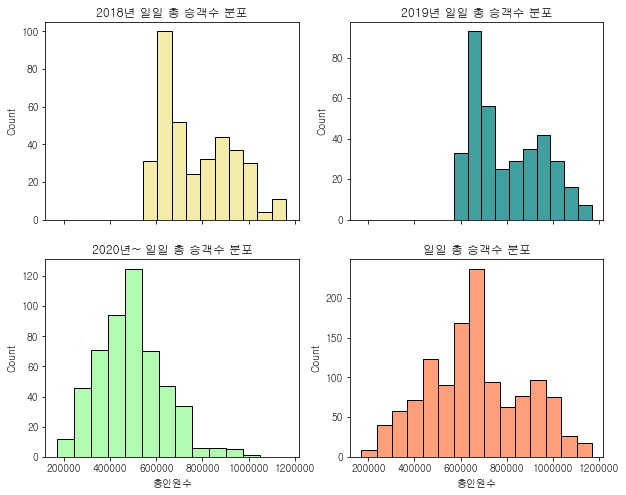

In [18]:
# 히스토그램을 통해 기간별 일일 총 승객수 분포 시각화
f,axes = plt.subplots(2,2,figsize=(10,8), sharex=True)

sns.histplot(df_day_sum['2018']['총인원수'], color='khaki', bins=10, ax=axes[0,0])
sns.histplot(df_day_sum['2019']['총인원수'], color='teal', bins=10, ax=axes[0,1])
sns.histplot(df_day_sum['2020':]['총인원수'], color='palegreen', bins=12, ax=axes[1,0])
sns.histplot(df_day_sum['총인원수'], color='coral', bins=15, ax=axes[1,1])

axes[0, 0].title.set_text("2018년 일일 총 승객수 분포")
axes[0, 1].title.set_text("2019년 일일 총 승객수 분포")
axes[1, 0].title.set_text("2020년~ 일일 총 승객수 분포")
axes[1, 1].title.set_text("일일 총 승객수 분포")

plt.show()

- 4번째 그래프인 일일 총 승객수 분포는 평균 70만명 정도의 대략적인 정규분포 형태를 띄고 있다.
- 그러나, 년도별로 나누면 2018년과 2019년은 일별 60만명 ~ 120만명의 승객수 분포를 보이는 반면, 2020년부터는 20만명 ~ 80만명의 승객수 분포를 보인다. 2018년과 2019년에 비해 2020년부터 승객수가 급감했음을 알 수 있다.

In [19]:
# 월평균 일일 승객수
df_month_daymean = df_day_sum.resample('m').mean()
df_month_daymean.head()

총인원수
운행일자                     
2018-01-31  708744.709677
2018-02-28  802123.642857
2018-03-31  741484.193548
2018-04-30  776326.266667
2018-05-31  815535.290323

- 앞선 일일 총 승객 수 데이터에서 월별로 나누어 평균을 낸 결과로, 월평균 승객 수를 나타낸다.

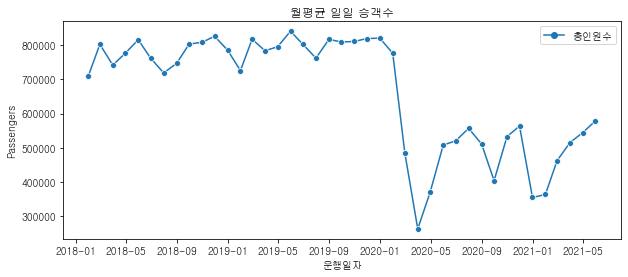

In [20]:
# 월평균 일일 승객수 시각화
plt.figure(figsize=(10,4))
sns.lineplot(data=df_month_daymean, markers=True)
plt.title('월평균 일일 승객수')
plt.ylabel('Passengers')
plt.show()

- 2018년부터 2020년 2월까지는 꾸준히 일일 80만명의 승객수를 유지했으나 2020년 초 코로나의 영향으로 승객수가 급감하였고, 이후에는 일일 50만명까지 회복했음을 알 수 있다.

In [21]:
# 2018년부터 2021년 5월까지 총 승객 수가 가장 많았던 역 TOP5, 가장 적었던 역 TOP5
df_station_day_sum.sum().sort_values(ascending=False)

정차역
서울     101789573.0
동대구     54420038.0
용산      49520433.0
대전      45934334.0
부산      42320453.0
          ...     
선평           413.0
제물포          398.0
덕정           376.0
비동           281.0
운천            32.0
Length: 291, dtype: float64

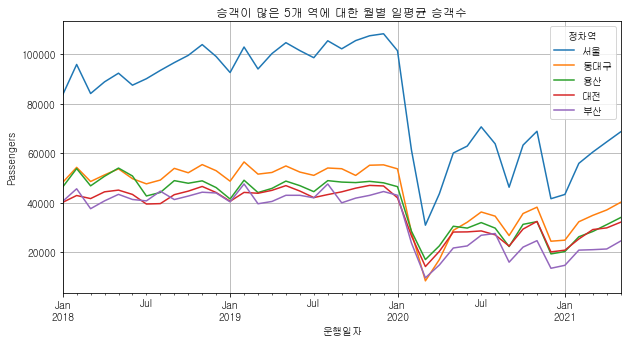

In [22]:
# 2018년 1월부터 2021년 5월까지 총 승객수가 가장 많았던 5개 역의 월별 일평균 승객수 시각화
df_station_day_sum[['서울', '동대구', '용산', '대전', '부산']].resample('m').mean().plot(grid=True, figsize=(10,5))
plt.title('승객이 많은 5개 역에 대한 월별 일평균 승객수')
plt.ylabel('Passengers')
plt.show()

- 가장 승객이 많았던 5개 역에 대한 그래프와 앞선 월평균 일일 총 승객수 그래프가 비슷한 추세인 것을 볼 수 있다. 2018년부터 2019년까지 비슷한 승객수를 유지하고, 2020년 초 급감 이후 현재까지 점차 회복세이다.

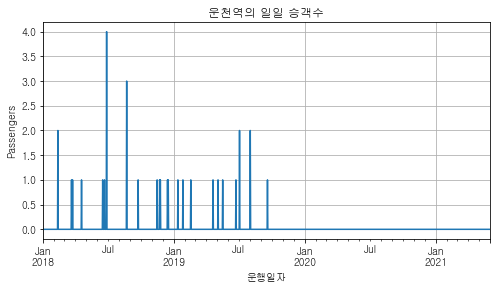

In [23]:
# 승객이 가장 적었던 운천역의 일일 승객수 시각화
df_station_day_sum['운천'].plot(grid=True, figsize=(8,4))
plt.title('운천역의 일일 승객수')
plt.ylabel('Passengers')
plt.show()

- 운천역은 2019년 9월 이후로 운행하지 않음을 확인할 수 있다.

In [24]:
# 열차종별 일일 총 승객수 데이터 생성
type_day_sum = df_station['총인원수'].groupby([df_station['운행일자'], df_station['역무열차종']]).sum()
df_type_day_sum = type_day_sum.unstack()
df_type_day_sum.fillna(0, inplace=True)
df_type_day_sum.head()

역무열차종       ITX-경부  ITX-새마을   ITX-청춘       KTX   KTX-산천  KTX-이음   KTX-호남  \
운행일자                                                                       
2018-01-01     0.0  62394.0  36366.0  306607.0  81456.0     0.0  47933.0   
2018-01-02  1176.0  34316.0  27994.0  222587.0  61297.0     0.0  34591.0   
2018-01-03   856.0  29588.0  25448.0  183951.0  55611.0     0.0  29772.0   
2018-01-04   880.0  29610.0  26186.0  196806.0  57795.0     0.0  31288.0   
2018-01-05  1550.0  42946.0  30774.0  280979.0  74735.0     0.0  28469.0   

역무열차종       공항버스   기타      누리로      무궁화호     새마을호    통근열차  
운행일자                                                       
2018-01-01   0.0  0.0  10534.0  320914.0  13908.0  2138.0  
2018-01-02   0.0  0.0   8716.0  269986.0   9310.0  1796.0  
2018-01-03   0.0  0.0   7428.0  241714.0   9996.0  1644.0  
2018-01-04   0.0  0.0   7726.0  242407.0  10542.0  1672.0  
2018-01-05   0.0  0.0   9734.0  302699.0  13144.0  1946.0

In [25]:
# 2018년부터 2021년 5월까지 열차종별 총 승객수
df_type_day_sum.sum().sort_values(ascending=False)

역무열차종
무궁화호       314279693.0
KTX        282434159.0
KTX-산천      82348384.0
ITX-새마을     49588074.0
ITX-청춘      35268390.0
KTX-호남      34744742.0
새마을호        13966415.0
누리로         10324098.0
공항버스         1863706.0
통근열차         1315830.0
KTX-이음        902360.0
기타            389196.0
ITX-경부         61828.0
dtype: float64

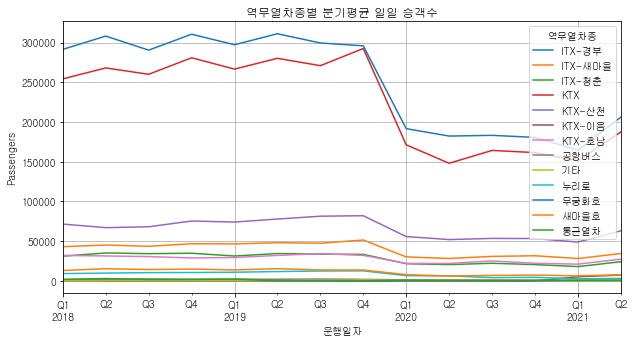

In [26]:
# 열차종별 분기평균 일일 승객수 시각화
df_type_day_sum.resample('Q').mean().plot(grid=True, figsize=(10,5))
plt.title('역무열차종별 분기평균 일일 승객수')
plt.ylabel('Passengers')
plt.show()

- 무궁화호, KTX도 2018년과 2019년에 비해 2020년 급감했음을 알 수 있다.

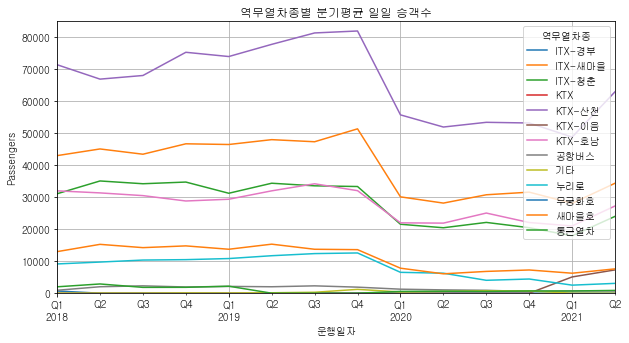

In [27]:
df_type_day_sum.resample('Q').mean().plot(grid=True, figsize=(10,5))
plt.title('역무열차종별 분기평균 일일 승객수')
plt.ylabel('Passengers')
plt.ylim(0,85000) # y축 범위 지정
plt.show()

- 다른 열차종도 마찬가지로 2020년 급감하는 추세를 보인다. 대신 승객수가 더 적은 열차종일수록 2020년 초 승객 감소비율이 줄어든다.

In [28]:
# 상하행별 일일 총 승객수 데이터 생성
updown_day_sum = df_station['총인원수'].groupby([df_station['운행일자'], df_station['상행하행구분']]).sum()
df_updown_day_sum = updown_day_sum.unstack()
df_updown_day_sum.fillna(0, inplace=True)
df_updown_day_sum.drop('상하행', axis='columns', inplace=True)
df_updown_day_sum.head()

상행하행구분            상행        하행
운행일자                          
2018-01-01  501329.0  380921.0
2018-01-02  355530.0  316239.0
2018-01-03  297275.0  288733.0
2018-01-04  308976.0  295936.0
2018-01-05  399623.0  387353.0

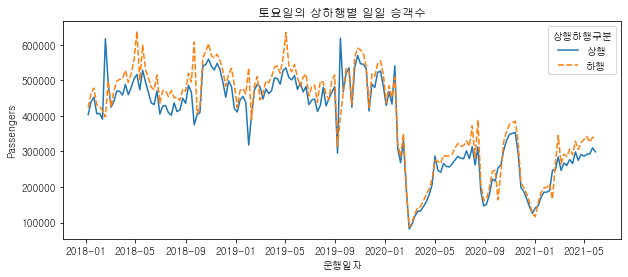

In [29]:
# 토요일의 상하행별 일일 총 승객수 시각화
plt.figure(figsize=(10,4))
sns.lineplot(data=df_updown_day_sum.query('운행일자.dt.dayofweek == 5'))
plt.title('토요일의 상하행별 일일 승객수')
plt.ylabel('Passengers')
plt.show()

- 토요일은 전체적으로 상행선보다 하행선의 승객수가 더 많은 것을 볼 수 있다.

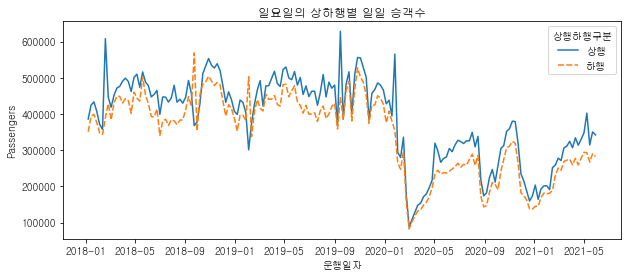

In [30]:
# 일요일의 상하행별 일일 총 승객수 시각화
plt.figure(figsize=(10,4))
sns.lineplot(data=df_updown_day_sum.query('운행일자.dt.dayofweek == 6'))
plt.title('일요일의 상하행별 일일 승객수')
plt.ylabel('Passengers')
plt.show()

- 일요일은 전체적으로 하행선보다 상행선의 승객수가 더 많은 것을 볼 수 있다.

### 2) 역 위치, 행정구역별 역 분포 시각화 (지도)

In [31]:
import folium
import json

In [32]:
# 역별 위치정보 파일 읽고 address column의 일부를 받아 DISTRICT column 생성
df_station_location = pd.read_excel('역별 주소정보.xlsx')
district = df_station_location['ADDRESS'].str.split(n=3, expand=True)
df_station_location['DISTRICT'] = district[1]
df_station_location

GUBUN LINE  STATION                     ADDRESS  LONGTITUDE   LATITUDE  \
0      광역  경부선  가산디지털단지       서울특별시 금천구 가산동 벚꽃로 309  126.882689  37.481505   
1      여객  가야선       가야             부산 부산진구 백양대로 91  129.039744  35.160446   
2      광역  경춘선       가평       경기도 가평군 가평읍 문화로 13-42  127.510842  37.814459   
3      여객  호남선       강경      충남 논산시 강경읍 대흥로 1 강경역무실  127.015992  36.153991   
4      여객  동해선       강구         경상북도 영덕군 강구면 강산로 67  129.370110  36.352495   
..    ...  ...      ...                         ...         ...        ...   
288    여객  경부선       황간  충북 영동군 황간면 하옥포2길 14  황간역무실  127.912289  36.224222   
289    광역  경원선       회기       서울시 동대문구 회기로 196(휘경동)  127.056409  37.588837   
290    광역  경원선       회룡            경기도 의정부시 평화로 363  127.047466  37.724344   
291    여객  경강선       횡성         강원도 횡성군 횡성읍 덕고로 591  128.007793  37.483013   
292    여객  경전선       효천             광주 남구 송하동 573-8  126.877114  35.102955   

    CITY DISTRICT  
0     서울      금천구  
1     부산     부산진구  
2     가평      가평군  
3     논산      논산시  
4     영덕      영덕군  
..   ...      ...  
288   영동      영동군  
289   서울     동대문구  
290  의정부     의정부시  
291   횡성      횡성군  
292   광주       남구  

[293 rows x 8 columns]

In [33]:
# 행정구역별 역 수 데이터 생성
df_station_city = pd.DataFrame(df_station_location.groupby(['DISTRICT'])['STATION'].count())
df_station_city.columns = ['역 수']
df_station_city.sort_values(by='역 수', ascending=False).head()

역 수
DISTRICT     
고양시        10
성남시         9
강남구         7
양평군         6
경주시         6

- 시군구 행정구역 중 가장 많은 역을 보유한 행정구역 5곳을 보여준다.

In [34]:
# 대한민국 행정구역 json 파일 읽기
with open('TL_SCCO_SIG.json',mode='rt', encoding='utf-8-sig') as f:
    geo = json.loads(f.read())
    f.close()

- 대한민국 시군구 행정구역 json 파일을 읽었다.

In [35]:
# 지도 시각화
map = folium.Map(
    location=[36.2906329,128.1665848],
    zoom_start=8
)

# json 파일로 행정구역 시각화
folium.GeoJson(
    geo,
    name='korea_municipalities'
).add_to(map)
map

# 역 마킹하기
for i in range(len(df_station_location)):
    folium.features.CircleMarker(
        [df_station_location.loc[i]['LATITUDE'], df_station_location.loc[i]['LONGTITUDE']],
        popup=df_station_location.loc[i]['STATION'],
        radius=5
    ).add_to(map)

# 행정구역의 역 수 시각화
folium.Choropleth(data=df_station_city['역 수'], 
                  geo_data=geo, 
                  columns=[df_station_city.index, df_station_city['역 수']], 
                  key_on='feature.properties.SIG_KOR_NM',
                  fill_color="BuPu",
                  bins=7
                  ).add_to(map)
map

- json 파일의 시군구 행정구역 정보와 역별 위치정보 데이터의 DISTRICT 컬럼의 값이 같은 경우, 해당 행정구역의 역 수를 시각화한 결과이다.
- 행정구역별로 코레일의 역이 얼마나 있는지를 시각적으로 알 수 있다. 향후 행정구역의 인구수, 역별 승객수 등의 데이터를 추가 고려하여 어느 행정구역에 역을 더 지어야 하는지를 파악할 수 있다.

### 3) 운행영업일 단계별 열차종 상관관계 시각화 (Heatmap)

In [36]:
# 운행영업일 단계별 열차종의 평균 승객수 데이터 생성
type_level_sum = df_station['총인원수'].groupby([df_station['역무열차종'], df_station['운행영업일단계']]).mean()
df_type_level_sum = type_level_sum.unstack()
df_type_level_sum.fillna(0, inplace=True)
df_type_level_sum = df_type_level_sum.T
df_type_level_sum

역무열차종        ITX-경부     ITX-새마을       ITX-청춘          KTX      KTX-산천  \
운행영업일단계                                                                 
공휴일        0.000000  324.576122  1563.153005  1485.583051  451.856879   
명절대수송    203.875000  390.596000  1389.334088  2042.274692  565.743191   
월, 금      86.690476  269.562574   967.866194  1661.988423  479.023534   
토, 일       0.000000  373.660049  1584.162928  1736.022033  518.094551   
화, 수, 목   55.753788  209.860275   854.351977  1330.492206  419.565762   

역무열차종        KTX-이음      KTX-호남        공항버스         기타         누리로  \
운행영업일단계                                                              
공휴일      411.407407  484.195006  330.688172   0.000000   93.797040   
명절대수송    292.955556  676.388916  253.105769  33.806452  100.913793   
월, 금     346.647222  440.655078  299.661467  30.924205   91.410737   
토, 일     431.545706  567.923046  328.587007   8.140503   99.881841   
화, 수, 목  275.532957  357.251430  264.788362  20.276286   76.337093   

역무열차종          무궁화호        새마을호        통근열차  
운행영업일단계                                      
공휴일      340.407106  128.792295  169.629091  
명절대수송    374.938694   98.801342  127.677419  
월, 금     333.410620  139.352254  136.888802  
토, 일     354.616137  128.988911  160.187919  
화, 수, 목  282.628098   99.235662  123.400158

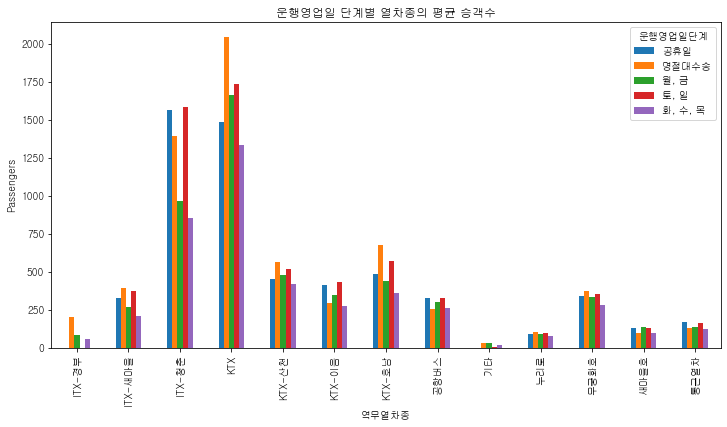

In [37]:
# 운행영업일 단계에 따른 열차종 분포 시각화
df_type_level_sum.T.plot(kind='bar', figsize=(12,6))
plt.title("운행영업일 단계별 열차종의 평균 승객수")
plt.ylabel("Passengers")
plt.show()

- ITX-청춘은 명절대수송 기간보다 공휴일에 더 승객이 많고, 휴일 승객수가 평일 승객수의 약 2배를 차지한다. KTX는 공휴일보다 평일에 오히려 더 승객이 많고, 명절대수송 기간엔 압도적으로 많은 승객수를 보인다.

In [38]:
# 상관계수 생성
corr = df_type_level_sum.corr()

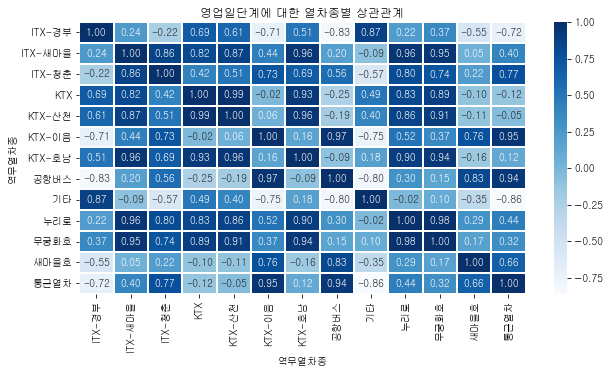

In [39]:
# 상관계수에 대한 히트맵 시각화
plt.figure(figsize=(10,5))
sns.heatmap(corr, annot=True, fmt=".2f", linewidth=1, cmap='Blues')
plt.title("영업일단계에 대한 열차종별 상관관계")
plt.show()

- 더 짙은 파란색일수록 강한 양의 상관관계, 흰색일수록 강한 음의 상관관계를 의미한다. 1에 가깝다면 두 열차종이 운행영업일 단계별로 비슷한 승객수 분포를 가지는 것이며, -1에 가깝다면 두 열차종이 운행영업일 단계별로 반대의 승객수 분포를 가지게 된다.

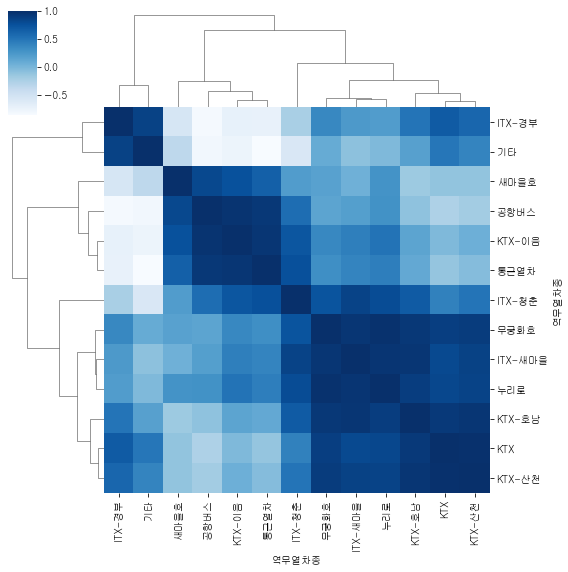

In [40]:
sns.clustermap(corr, figsize=(8,8), cmap='Blues')

- 운행영업일 단계별로 비슷한 승객수 분포를 보이는 열차종끼리 묶은 것을 나타낸 것이다. 크게 3개의 cluster로 나뉘는 것을 볼 수 있는데, 무궁화호, KTX, KTX-호남, KTX-산천, 누리로, ITX-새마을이 같은 cluster로 묶인다.

### 4) 요일별 승객 수 시각화 (Pie Chart)

In [41]:
#고객 특성 csv 파일 읽기 - 고객 회원 여부 예측, 시각화
df_client19 = pd.read_csv('고객 특성별 철도서비스 이용정보(강릉,목포,전주)_2019.csv')
df_client20 = pd.read_csv('고객 특성별 철도서비스 이용정보(강릉,목포,전주)_2020.csv')
df_client21 = pd.read_csv('고객 특성별 철도서비스 이용정보(강릉,목포,전주)_2021.csv')

In [42]:
#고객 특성 데이터 합치기
df_client = pd.concat([df_client19, df_client20, df_client21], ignore_index=True)
df_client.tail()

운행일자 운행요일  구분  출발시간대 성별     연령대 고객등급_현재    출발역코드 출발역명    도착역코드  \
1632175  20210531    월  회원   23.0  M  20~29세       F  3900195  서대전  3900248   
1632176  20210531    월  회원   23.0  M  20~29세       F  3900259   남원  3900248   
1632177  20210531    월  회원   23.0  M  30~39세       F  3900195  서대전  3900248   
1632178  20210531    월  회원   23.0  M  40~49세       F  3900271   순천  3900248   
1632179  20210531    월  회원   23.0  M  50~59세       F  3900141   만종  3900587   

        도착역명 상하행구분    노선  역무열차종코드   역무열차종  인원  
1632175   전주     D  1040        2    무궁화호   1  
1632176   전주     U   943        2    무궁화호   1  
1632177   전주     D  1040        2    무궁화호   2  
1632178   전주     U   943        2    무궁화호   1  
1632179   강릉     D  2134       10  KTX-호남   1

In [43]:
# 각 요일에 코레일을 이용한 승객 수
week_of_the_day = df_client['운행요일'].value_counts()
week_of_the_day

금    283677
일    271706
토    266988
월    216574
목    207375
수    193226
화    192634
Name: 운행요일, dtype: int64

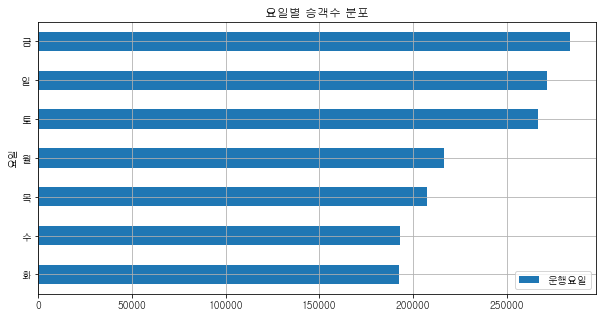

In [44]:
# 요일별 승객수 시각화
week_of_the_day.sort_values().plot(kind='barh', figsize=(10,5), grid=True)
plt.title('요일별 승객수 분포')
plt.legend(loc="best")
plt.ylabel("요일")
plt.show()

금요일에 이용 승객이 제일 많았음을 알 수 있고, 화요일에 제일 적었음을 알 수 있다.

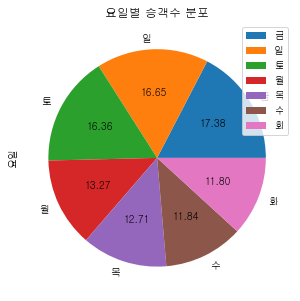

In [45]:
# 파이 차트로 시각화
week_of_the_day.plot(kind='pie', figsize=(8,5), autopct='%.2f')
plt.title('요일별 승객수 분포')
plt.legend(loc="best")
plt.ylabel("요일")
plt.show()

- 금요일에 코레일 이용 승객이 17.38%로 가장 많았고, 금,토,일의 승객 수가 전체 승객 수의 약 50%를 차지한다.
- 화요일과 수요일에 11.8%로 가장 승객이 적다.

### 5) 열차종별 연령대, 성별 분포 시각화 (Countplot)

In [46]:
# 고객 데이터에서 연령대와 역무열차종 column만 추출해 새로운 데이터프레임 생성
df_age_train = df_client[['연령대', '역무열차종']].dropna()
df_age_train

연령대   역무열차종
0            기타    무궁화호
1            기타    무궁화호
2            기타    무궁화호
3            기타    무궁화호
4            기타    무궁화호
...         ...     ...
1632175  20~29세    무궁화호
1632176  20~29세    무궁화호
1632177  30~39세    무궁화호
1632178  40~49세    무궁화호
1632179  50~59세  KTX-호남

[1632180 rows x 2 columns]

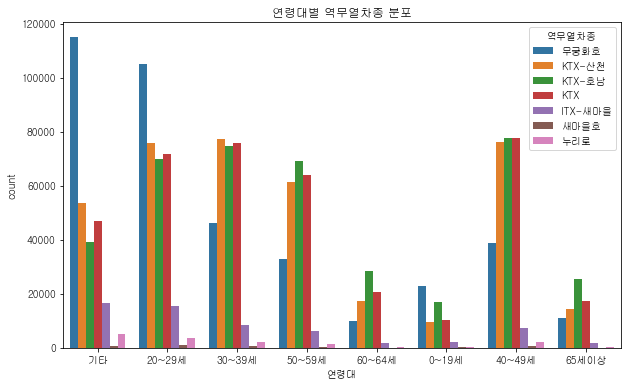

In [47]:
# countplot을 이용해 연령대별 역무열차종 분포 시각화
plt.figure(figsize=(10,6))
sns.countplot(x='연령대', hue='역무열차종', data=df_age_train)
plt.title("연령대별 역무열차종 분포")
plt.show()

- 미성년자, 20대는 KTX보다 무궁화호를 타는 비율이 높은 반면, 30대부터는 KTX를 타는 비율이 높다. 또한, 나이가 많을수록 KTX-호남 열차를 타는 비율이 증가함을 알 수 있다.
- 코레일 비회원 승객들은 연령대가 기타로 나타나는데, 비회원 승객들 중 무궁화호를 탑승한 승객의 비율이 높은 것을 확인할 수 있다.

In [48]:
# 고객 데이터에서 성별과 역무열차종 column만 추출해 새로운 데이터프레임 생성
df_sex_train = df_client[['성별', '역무열차종']].dropna()
df_sex_train.head()

성별 역무열차종
670  F  무궁화호
671  F  무궁화호
672  M  무궁화호
673  M  무궁화호
674  M  무궁화호

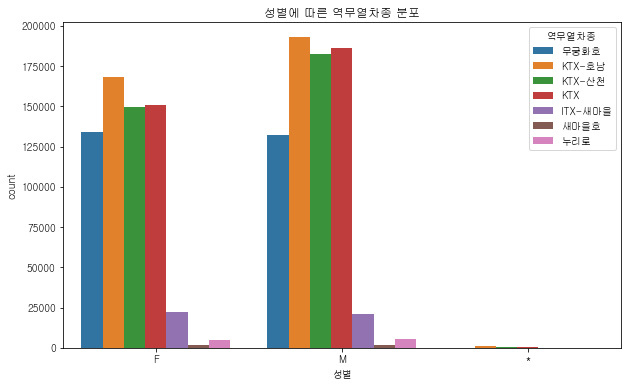

In [49]:
plt.figure(figsize=(10,6))
sns.countplot(x='성별', hue='역무열차종', data=df_sex_train)
plt.title("성별에 따른 역무열차종 분포")
plt.show()

- 여성 승객의 무궁화호 탑승 비율이 남성 승객의 무궁화호 탑승 비율보다 더 높음을 알 수 있다.

## 4. 시계열 데이터로 일일 승객 수 예측

In [50]:
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

### - AR, MA, ARIMA, SARIMA, Prophet, SES, HWES : 7가지 모델 비교

In [51]:
df_day_sum

총인원수
운행일자                
2018-01-01  882250.0
2018-01-02  671769.0
2018-01-03  586008.0
2018-01-04  604912.0
2018-01-05  786976.0
...              ...
2021-05-27  506442.0
2021-05-28  692104.0
2021-05-29  632940.0
2021-05-30  624818.0
2021-05-31  501772.0

[1247 rows x 1 columns]

- 승객 수 예측에 사용될 코레일의 일일 총 승객수 데이터이다.

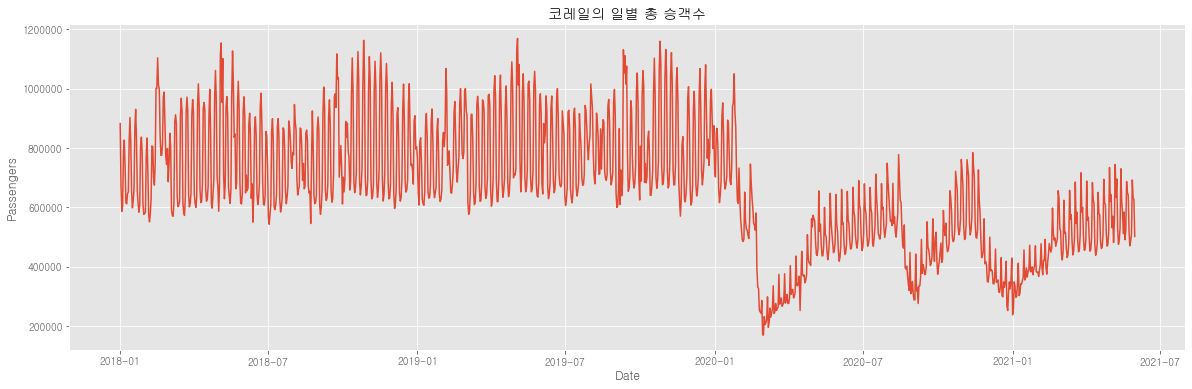

In [52]:
# 코레일의 일별 총 승객수 시각화
plt.figure(figsize=(20,6))
plt.plot(df_day_sum)
plt.title("코레일의 일별 총 승객수")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.show()

<Figure size 432x288 with 0 Axes>

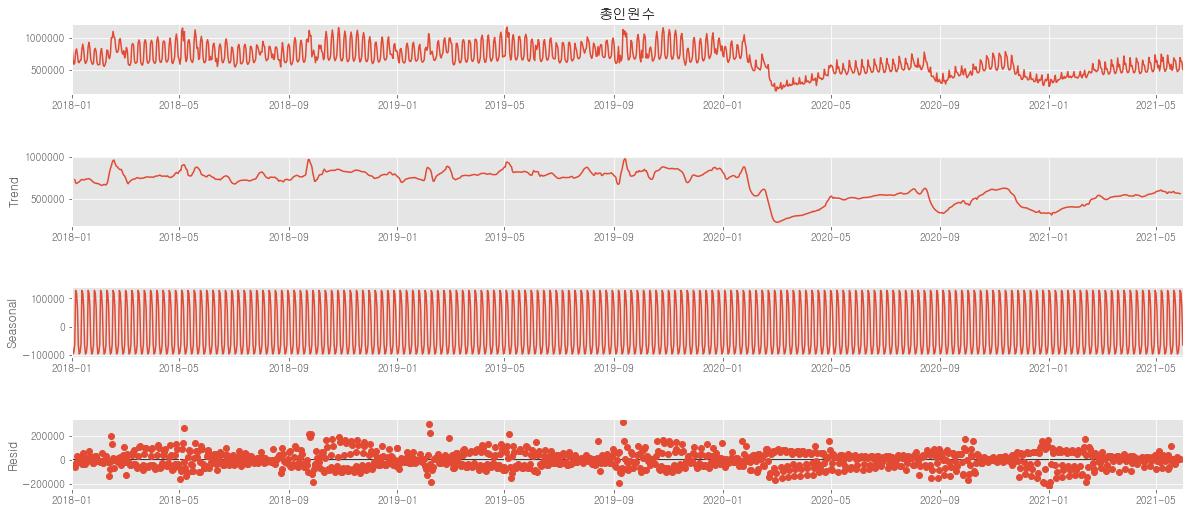

In [53]:
# 시계열 분해법으로 분해
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_day_sum['총인원수'], model='additive', period=7)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,8)

- trend와 seasonal을 파악하고 정상성을 확인하기 위해 시계열 분해법을 진행한다.
- trend에서 기간별 승객수 추세가 나타난다.
- seasonal에서도 데이터가 패턴을 보이기 때문에 정상성이 없다고 볼 수 있다.
(정상성 : 평균, 분산이 시간에 따라 일정한 성질)

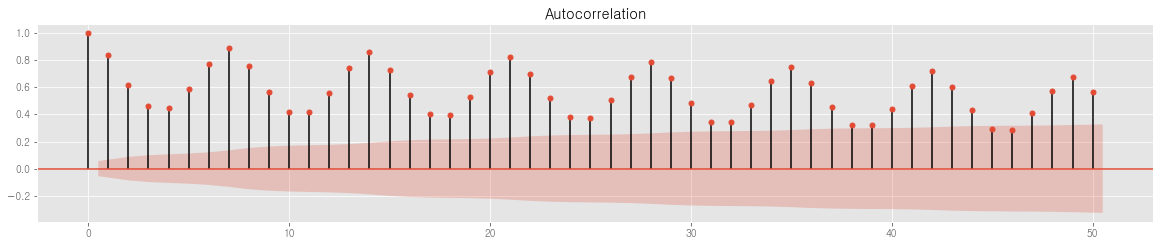

In [54]:
# ACF 그래프 시각화
import statsmodels.api as sm

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_day_sum, lags=50, ax=ax1)

- ACF는 시차에 따른 데이터의 관계를 나타낸다.
- ACF 값이 시차가 늘어날수록 천천히 감소하고 있기 때문에 데이터에 추세가 존재한다.
- ACF가 시차 7의 주기로 같은 패턴을 가지는데, 일주일 주기로 비슷한 승객 수 분포를 가지는 것을 의미하게 되어 데이터에 계절성이 존재한다.
- 즉, 정상성을 만족하지 않는 것을 확인할 수 있다.

In [55]:
# ADF 검정
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_day_sum)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values: ')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.968447
p-value: 0.300577
Critical Values: 
	1%: -3.436
	5%: -2.864
	10%: -2.568


- ADF 검정을 통해 정상성 확인
- H0(귀무가설) : 정상성 불만족
- H1(대립가설) : 정상성 만족
- p-value가 0.05를 넘기 때문에 대립가설을 기각하므로 정상성을 만족하지 못한다.

In [56]:
# 1차 차분 진행
df_day_sum_diff = df_day_sum - df_day_sum.shift()

- ARIMA 모델은 정상성을 가정하는 모델이므로 미리 정상성을 만족시켜야 한다.
- 데이터에 추세와 계절성을 제거하는 차분이라는 방법을 통해 정상성을 만족시킬 수 있다.

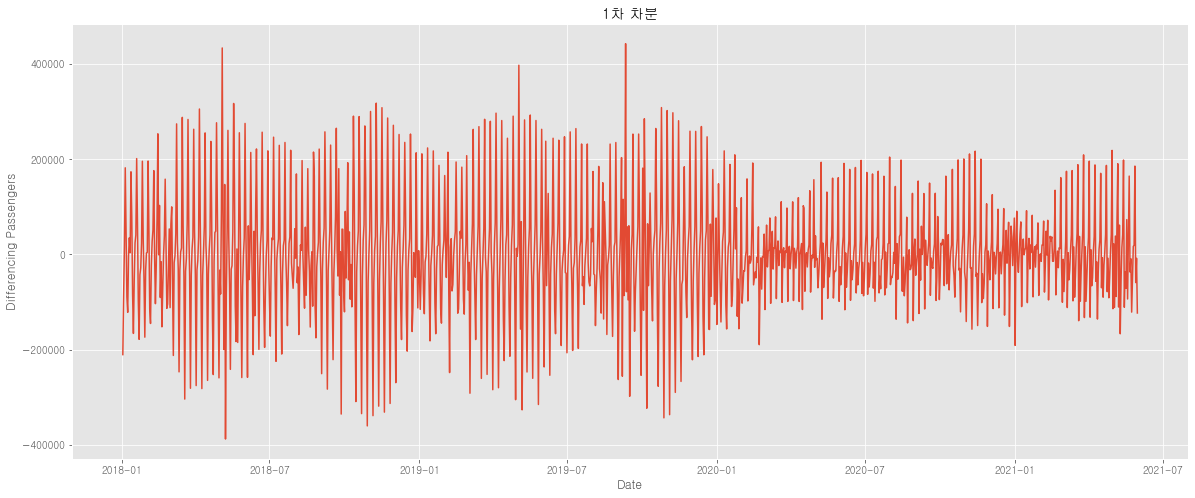

In [57]:
# 1차 차분 결과 시각화
plt.figure(figsize=(20,8))
plt.plot(df_day_sum_diff)
plt.title("1차 차분")
plt.xlabel("Date")
plt.ylabel("Differencing Passengers")
plt.show()

In [58]:
# ADF 검정
result = adfuller(df_day_sum_diff[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values: ')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.772552
p-value: 0.000000
Critical Values: 
	1%: -3.436
	5%: -2.864
	10%: -2.568


- p-value가 0.05보다 작으므로 귀무가설을 기각한다. 즉, 1차 차분한 데이터는 정상성을 만족한다.

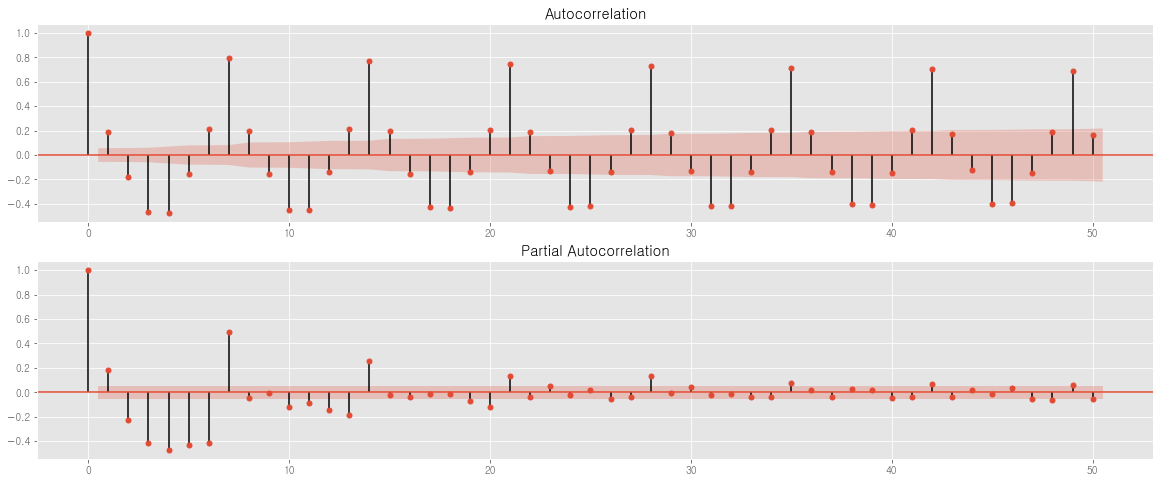

In [59]:
import statsmodels.api as sm

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_day_sum_diff[1:], lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_day_sum_diff[1:], lags=50, ax=ax2)

- 1차 차분한 이후, 정상성이 만족한 이후 ACF와 PACF를 통해 MA모델과 AR모델의 파라미터를 도출할 수 있다.
- ACF 값은 주기가 7을 가지므로, MA 모델의 파라미터 q = 7로 설정한다.
- PACF 값도 마찬가지로 7의 주기를 가지므로 AR 모델의 파라미터 p = 7로 설정한다.

In [60]:
y1 = df_day_sum['총인원수'].resample('1D').mean()
y1

운행일자
2018-01-01    882250.0
2018-01-02    671769.0
2018-01-03    586008.0
2018-01-04    604912.0
2018-01-05    786976.0
                ...   
2021-05-27    506442.0
2021-05-28    692104.0
2021-05-29    632940.0
2021-05-30    624818.0
2021-05-31    501772.0
Freq: D, Name: 총인원수, Length: 1247, dtype: float64

(AR,MA 모델은 전체 데이터를 학습시켜야 하므로 AR,MA 모델에서만 사용)

In [61]:
# train set, test set 분할
df_train = df_day_sum['2018-01-01':'2021-04-30']
df_test = df_day_sum['2021-05-01':]

train = df_train.values
test = df_test.values

- 2018년부터 2021년 4월까지의 데이터로 모델을 학습시키고, 2021년 5월의 승객 수를 예측한다.

### 1) AutoRegression (AR) 모델 

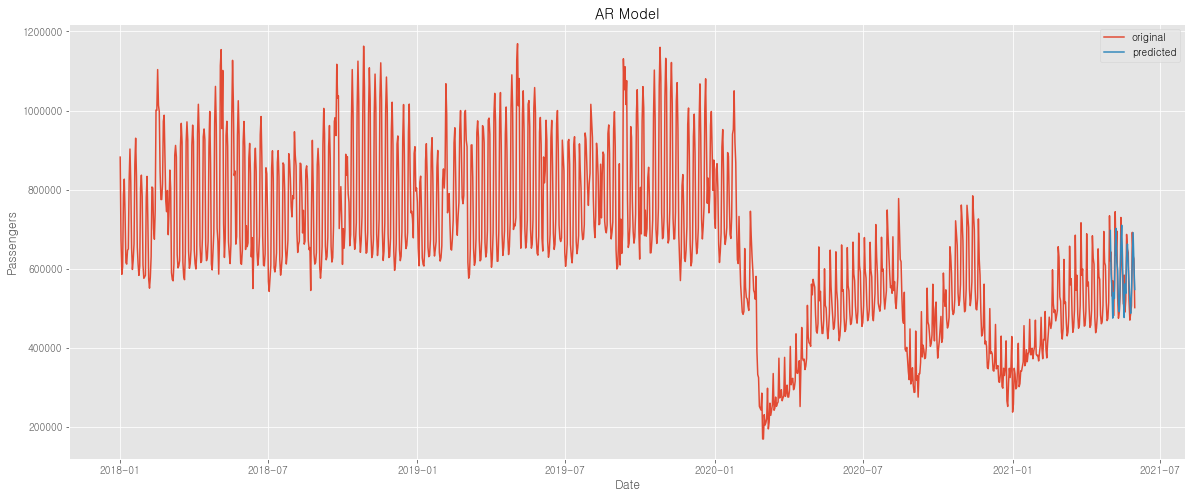

In [62]:
from statsmodels.tsa.ar_model import AutoReg

# AR 모델 학습
model = AutoReg(y1, lags=7)
model_fit = model.fit()

# 모델 예측
y_pred_ar = model_fit.predict(len(train), len(train)+len(test)-1)

# train data, test data 같이 시각화
plt.figure(figsize=(20,8))
plt.plot(df_day_sum, label='original')
plt.plot(y_pred_ar, label='predicted')
plt.title("AR Model")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()

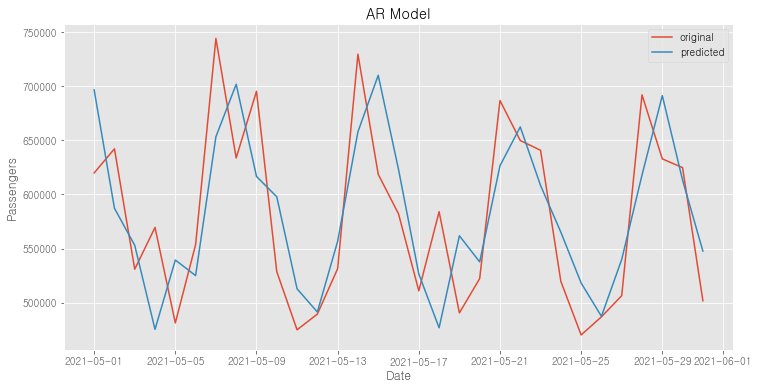

In [63]:
# 2021년 5월 데이터에 대해서만 시각화
plt.figure(figsize=(12,6))
plt.plot(df_day_sum['2021-05'], label='original')
plt.plot(y_pred_ar, label='predicted')
plt.title("AR Model")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()

- 예측 모델이 실제 모델의 추세를 따라가고는 있지만 오차가 존재해 좋은 성능을 보이지는 않는다.

In [64]:
# RMSE, MAPE로 모델 성능 평가
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
MAPE_ar = MAPE(test, y_pred_ar.values)
RMSE_ar = mean_squared_error(test, y_pred_ar.values)**0.5
r2_ar = r2_score(test, y_pred_ar.values)
print('RMSE: %.3f' % RMSE_ar)
print('MAPE: %.3f' % MAPE_ar)
print('R-Squared: %.3f' % r2_ar)

RMSE: 57441.140
MAPE: 14.987
R-Squared: 0.486


### 2) Moving Average (MA) 모델

In [65]:
from statsmodels.tsa.arima.model import ARIMA

# MA 모델 학습
model = ARIMA(y1, order=(0,0,7))
model_fit = model.fit()

# 모델 예측
y_pred_ma = model_fit.predict(len(train), len(train)+len(test)-1)

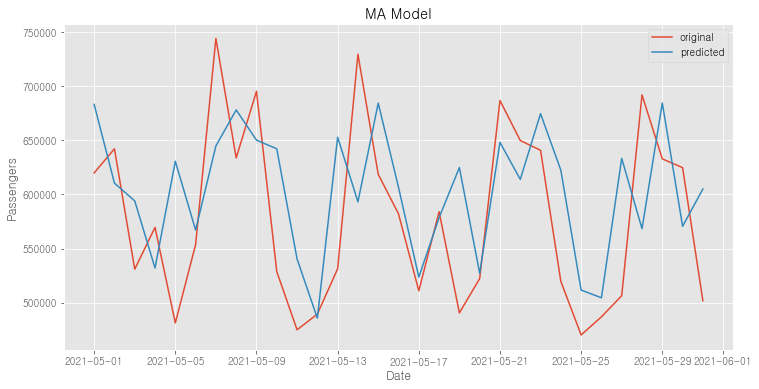

In [66]:
plt.figure(figsize=(12,6))
plt.plot(df_day_sum['2021-05'], label='original')
plt.plot(y_pred_ma, label='predicted')
plt.title("MA Model")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()

- AR 모델보다 오차가 더 큰 것을 대략적으로 파악할 수 있다.

In [67]:
# RMSE, MAPE로 모델 성능 평가
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

MAPE_ma = MAPE(test, y_pred_ma.values)
RMSE_ma = mean_squared_error(test, y_pred_ma.values)**0.5
r2_ma = r2_score(test, y_pred_ma.values)

print('RMSE: %.3f' % RMSE_ma)
print('MAPE: %.3f' % MAPE_ma)
print('R-Squared: %.3f' % r2_ma)

RMSE: 77232.520
MAPE: 15.009
R-Squared: 0.072


### 3) ARIMA 모델 

In [68]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# ARIMA 모델 학습 (AR=7, 차분=1, MA=7)
model = ARIMA(df_day_sum[:'2021-04'], order=(7,1,7))
model_fit = model.fit()

y_pred_arima = model_fit.predict(len(train), len(train)+len(test)-1, typ='levels')

C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


- ARIMA 모델은 정상성을 가정하므로 차분의 결과를 반영해야 한다. 앞서 1번 차분 이후 정상성을 만족했으므로, d = 1로 설정한다.

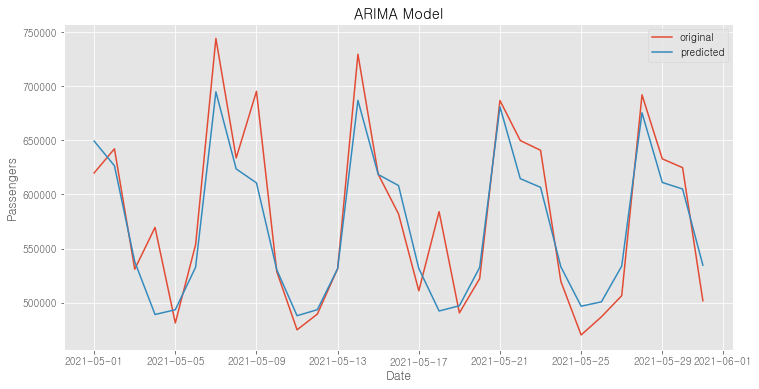

In [69]:
plt.figure(figsize=(12,6))
plt.plot(df_day_sum['2021-05'], label='original')
plt.plot(y_pred_arima, label='predicted')
plt.title("ARIMA Model")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()

In [70]:
# RMSE, MAPE로 모델 성능 평가
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

MAPE_arima = MAPE(test, y_pred_arima.values)
RMSE_arima = mean_squared_error(test, y_pred_arima.values)**0.5
r2_arima = r2_score(test, y_pred_arima.values)

print('RMSE: %.3f' % RMSE_arima)
print('MAPE: %.3f' % MAPE_arima)
print('R-Squared: %.3f' % r2_arima)

RMSE: 34144.044
MAPE: 14.404
R-Squared: 0.819


- R-Squared가 0.8 이상이 나와 예측 모델이 실제 모델을 80% 이상 설명할 수 있으므로 모델이 목표를 달성했다.

### 4) SARIMA 모델

In [71]:
import itertools

In [72]:
# 검사할 하이퍼파라미터 설정
p = q = range(1,3)
d = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p,d,q))]
seasonal_pdq

[(1, 0, 1, 7),
 (1, 0, 2, 7),
 (1, 1, 1, 7),
 (1, 1, 2, 7),
 (2, 0, 1, 7),
 (2, 0, 2, 7),
 (2, 1, 1, 7),
 (2, 1, 2, 7)]

- Grid-Search를 통해 최적의 하이퍼파라미터 조합을 도출하기 위해 전체 시계열에 대한 p, d, q와 주기 패턴에 대한 P, D, Q의 범위를 설정했다.

In [73]:
param_list = []
param_seasonal_list = []
results_AIC_list = []

In [74]:
# 설정한 하이퍼파라미터 조합들 중 최적의 조합 찾기 (최저 AIC 값)
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_day_sum[:'2021-04'], order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
            results = mod.fit()
            param_list.append(param)
            param_seasonal_list.append(param_seasonal)
            results_AIC_list.append(results.aic)
        except:
            continue

C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\

C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\

C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Us

C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


- 설정한 모든 하이퍼파라미터 조합으로 모델링을 진행하고 AIC값을 구한다.

In [75]:
ARIMA_list = pd.DataFrame({'Parameter':param_list, 'Seasonal':param_seasonal_list, 'AIC':results_AIC_list})

In [76]:
ARIMA_list.sort_values(by='AIC')

Parameter      Seasonal           AIC
43  (2, 0, 2)  (1, 1, 2, 7)  29665.800835
47  (2, 0, 2)  (2, 1, 2, 7)  29667.748958
11  (1, 0, 2)  (1, 1, 2, 7)  29673.489961
15  (1, 0, 2)  (2, 1, 2, 7)  29675.369986
46  (2, 0, 2)  (2, 1, 1, 7)  29693.488616
..        ...           ...           ...
32  (2, 0, 1)  (1, 0, 1, 7)  30676.496620
28  (1, 1, 2)  (2, 0, 1, 7)  30682.300659
16  (1, 1, 1)  (1, 0, 1, 7)  30690.001842
61  (2, 1, 2)  (2, 0, 2, 7)  30700.087120
0   (1, 0, 1)  (1, 0, 1, 7)  30702.239686

[64 rows x 3 columns]

- AIC가 가장 낮은 하이퍼파라미터 조합이 최적의 하이퍼파라미터 조합이 된다.

In [77]:
# AIC값이 가장 낮은 하이퍼파라미터 조합에 대해 SARIMA 모델링
model = sm.tsa.SARIMAX(y1, order=(2,0,2), seasonal_order=(1,1,2,7),
                      enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()

y_pred_sari = model_fit.predict(len(train), len(train)+len(test)-1)

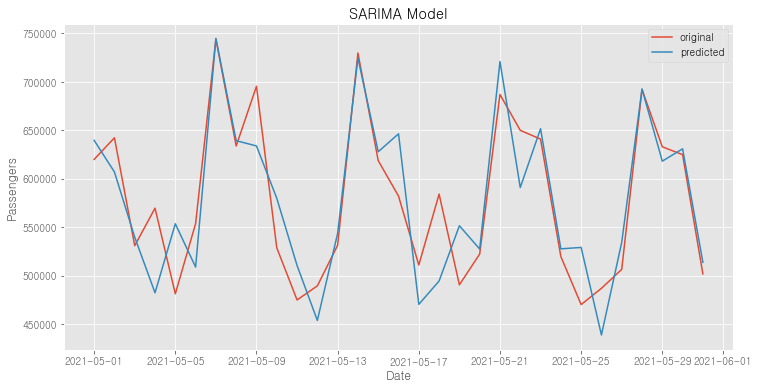

In [78]:
plt.figure(figsize=(12,6))
plt.plot(df_day_sum['2021-05'], label='original')
plt.plot(y_pred_sari, label='predicted')
plt.title("SARIMA Model")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()

- 승객 수가 많을 때는 거의 오차 없이 예측이 잘 되지만, 승객 수가 적었을 때는 오차가 존재하는 것을 볼 수 있다.

In [79]:
# RMSE, MAPE로 모델 성능 평가
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

MAPE_sari = MAPE(test, y_pred_sari.values)
RMSE_sari = mean_squared_error(test, y_pred_sari.values)**0.5
r2_sari = r2_score(test, y_pred_sari.values)

print('RMSE: %.3f' % RMSE_sari)
print('MAPE: %.3f' % MAPE_sari)
print('R-Squared: %.3f' % r2_sari)

RMSE: 42173.976
MAPE: 15.915
R-Squared: 0.723


### 5) Facebook - Prophet 모델

In [80]:
from fbprophet import Prophet

df_day_sum['ds'] = pd.to_datetime(df_day_sum.index, format='%y-%m-%d')
df_day_sum['y'] = df_day_sum['총인원수']
df = df_day_sum[['ds','y']]

# Prophet 모델 학습
m = Prophet(daily_seasonality=False, changepoint_range=0.96)
prophet_fit = m.fit(df[:'2021-04'])
future = m.make_future_dataframe(periods=31)
df_forecast = m.predict(future)

# 예측 결과 출력 (yhat_lower부터 yhat_upper까지 범위로 제공)
df_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']]

Importing plotly failed. Interactive plots will not work.


ds           yhat     yhat_lower    yhat_upper
0    2018-01-01  704115.778795  567570.115393  8.448644e+05
1    2018-01-02  669734.756345  538099.938693  7.959118e+05
2    2018-01-03  675511.504483  531441.515957  8.102167e+05
3    2018-01-04  702775.077290  570236.475732  8.308071e+05
4    2018-01-05  892992.477916  764236.092879  1.033622e+06
...         ...            ...            ...           ...
1242 2021-05-27  509780.652736  362695.903386  6.419140e+05
1243 2021-05-28  698822.591575  561748.064767  8.357497e+05
1244 2021-05-29  690082.398606  553295.861942  8.292066e+05
1245 2021-05-30  637171.055533  495202.552420  7.667498e+05
1246 2021-05-31  506016.250444  377805.649201  6.393319e+05

[1247 rows x 4 columns]

- 예측 값 yhat에 상한 yhat_upper, 하한 yhat_lower을 통해 예측 범위도 제공한다.

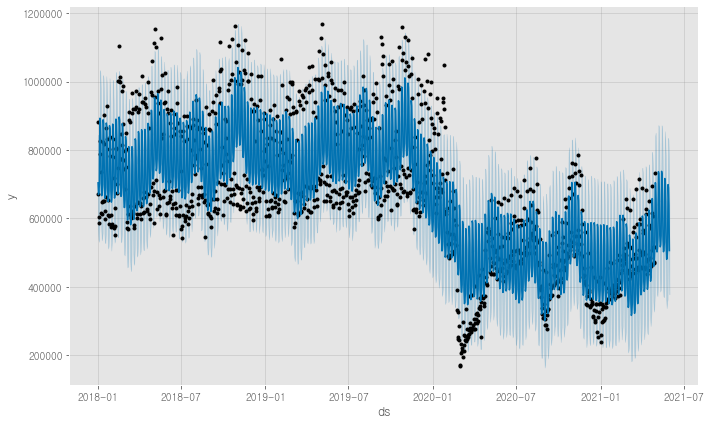

In [81]:
fig1 = m.plot(df_forecast)

- 검은 점이 실제 값, 진한 파란색 선이 예측 값, 연한 파란색 선이 예측 범위이다.
- 2020년 초 승객이 급감했을 때를 제외하면 예측 범위 안에 실제 값이 대부분 포함되어 있는 것을 볼 수 있다.

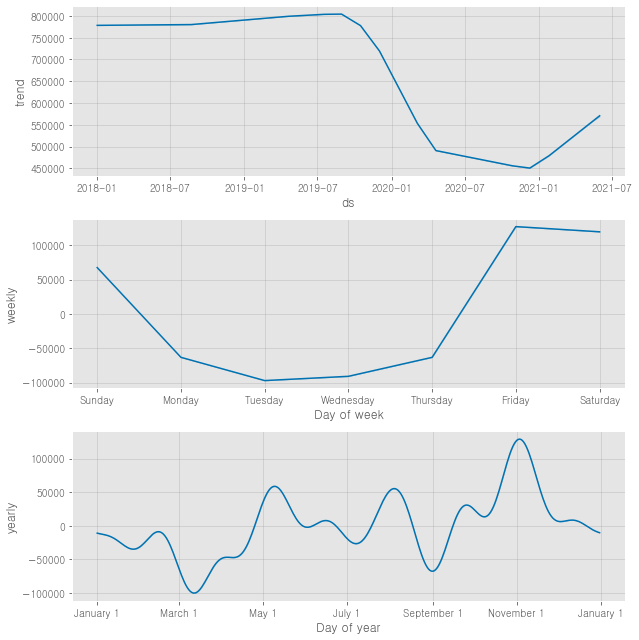

In [82]:
fig2 = m.plot_components(df_forecast)

- 전체 추세, 요일별 추세, 월별 추세를 볼 수 있다.

In [83]:
# 만든 ds, y column 제거
df_day_sum.drop(['ds','y'], axis=1, inplace=True)

In [84]:
y_pred_prophet = df_forecast[['ds','yhat']]
y_pred_prophet.set_index('ds', inplace=True)
y_pred_prophet.head()

yhat
ds                       
2018-01-01  704115.778795
2018-01-02  669734.756345
2018-01-03  675511.504483
2018-01-04  702775.077290
2018-01-05  892992.477916

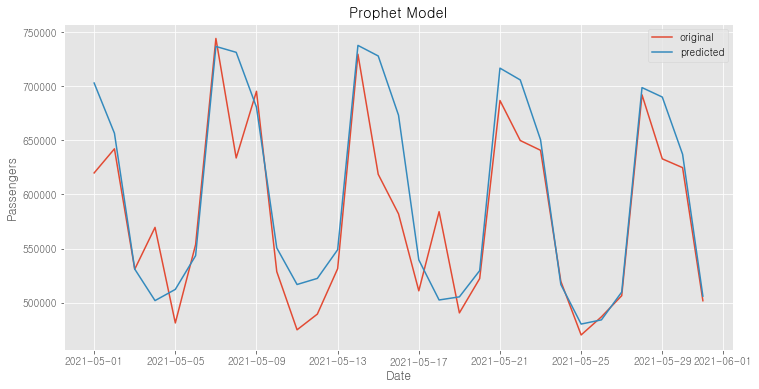

In [85]:
plt.figure(figsize=(12,6))
plt.plot(df_day_sum['2021-05'], label='original')
plt.plot(y_pred_prophet['2021-05'], label='predicted')
plt.title("Prophet Model")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()

- 예측 모델에 변동이 거의 없는 것을 볼 수 있다.
- 매우 정밀한 예측보다 예측 범위를 제공함으로써 일정 수준 이상의 예측률을 꾸준히 기록하는 것으로 해석할 수 있다.

In [86]:
# RMSE, MAPE로 모델 성능 평가
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

MAPE_prophet = MAPE(test, y_pred_prophet['2021-05'].values)
RMSE_prophet = mean_squared_error(test, y_pred_prophet['2021-05'].values)**0.5
r2_prophet = r2_score(test, y_pred_prophet['2021-05'].values)

print('RMSE: %.3f' % RMSE_prophet)
print('MAPE: %.3f' % MAPE_prophet)
print('R-Squared: %.3f' % r2_prophet)

RMSE: 44741.893
MAPE: 5.391
R-Squared: 0.688


- MAPE가 약 5%로 매우 낮은 평균 오차를 기록해 모델이 목표에 달성했다.

### 6) Simple Exponential Smoothing (SES) 모델

In [87]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

# Grid-Search를 통해 MAPE가 가장 낮은 최적의 alpha값 찾기 
for alpha in [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3, 0.5]:
    model = SimpleExpSmoothing(df_day_sum[:'2021-04'])
    model_fit = model.fit(smoothing_level=alpha)
    y_pred_ses = model_fit.predict(len(train), len(train)+len(test)-1)
    MAPE_ses = MAPE(test, y_pred_ses['2021-05'].values)
    print(f"alpha = {alpha}, mape = {MAPE_ses}")

alpha = 0.01, mape = 14.508417019688
alpha = 0.02, mape = 12.861403985139905
alpha = 0.03, mape = 11.93079291419708
alpha = 0.05, mape = 11.728508348564501
alpha = 0.07, mape = 11.75443042484105
alpha = 0.1, mape = 11.776824000137857
alpha = 0.2, mape = 11.989563401950809
alpha = 0.3, mape = 12.361889208980463
alpha = 0.5, mape = 14.179043839215625


C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kms10\

- Grid-Search를 통해 MAPE가 가장 낮은 하이퍼파라미터 alpha를 도출한다.

In [88]:
# alpha = 0.05으로 모델링
model = SimpleExpSmoothing(df_day_sum[:'2021-04'])
model_fit = model.fit(smoothing_level=0.05)
y_pred_ses = model_fit.predict(len(train), len(train)+len(test)-1)

C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


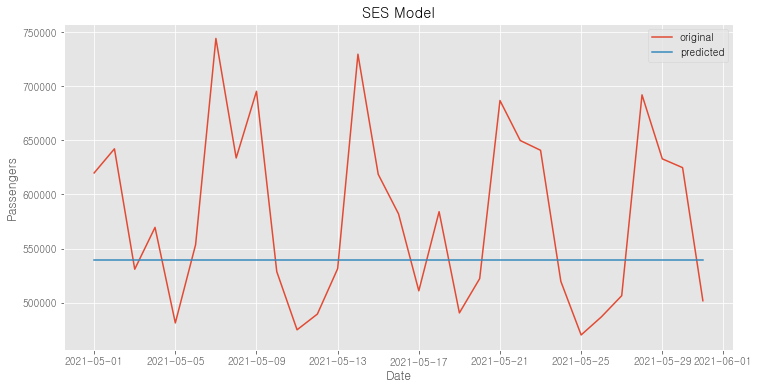

In [89]:
plt.figure(figsize=(12,6))
plt.plot(df_day_sum['2021-05'], label='original')
plt.plot(y_pred_ses, label='predicted')
plt.title("SES Model")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()

- SES 모델은 수평적 추세만 반영하므로 전부 같은 값으로 예측 값이 나온다.

In [90]:
# RMSE, MAPE로 모델 성능 평가
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

MAPE_ses = MAPE(test, y_pred_ses['2021-05'].values)
RMSE_ses = mean_squared_error(test, y_pred_ses['2021-05'].values)**0.5
r2_ses = r2_score(test, y_pred_ses.values)

print('RMSE: %.3f' % RMSE_ses)
print('MAPE: %.3f' % MAPE_ses)
print('R-Squared: %.3f' % r2_ses)

RMSE: 89343.726
MAPE: 11.729
R-Squared: -0.242


### 7) Holt Winter's Exponential Smoothing (HWES) 모델

In [91]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(df_day_sum[:'2021-04'], trend='add', seasonal='additive', seasonal_periods=7)
model_fit = model.fit()
y_pred_hwes = model_fit.predict(len(train), len(train)+len(test)-1)

C:\Users\kms10\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


- HWES 모델은 SES 모델에 추세와 계절성을 반영하므로, trend, seasonal과 periods 옵션을 추가해 모델링한다.

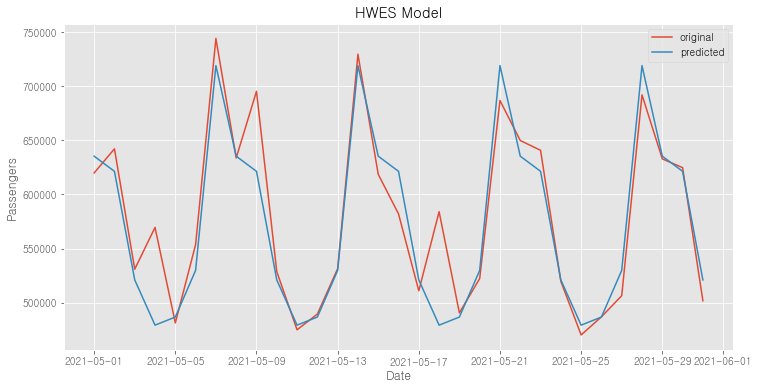

In [92]:
plt.figure(figsize=(12,6))
plt.plot(df_day_sum['2021-05'], label='original')
plt.plot(y_pred_hwes, label='predicted')
plt.title("HWES Model")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()

- 전체 추세에 위배되는 일부 불규칙적인 피크를 제외하면 대부분 매우 정확한 예측을 보이는 것을 확인할 수 있다.

In [93]:
# RMSE, MAPE로 모델 성능 평가
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

MAPE_hwes = MAPE(test, y_pred_hwes['2021-05'].values)
RMSE_hwes = mean_squared_error(test, y_pred_hwes['2021-05'].values)**0.5
r2_hwes = r2_score(test, y_pred_hwes.values)

print('RMSE: %.3f' % RMSE_hwes)
print('MAPE: %.3f' % MAPE_hwes)
print('R-Squared: %.3f' % r2_hwes)

RMSE: 32243.574
MAPE: 15.672
R-Squared: 0.838


- R-Squared가 약 0.84로 예측 모델이 실제 모델을 매우 잘 설명한다.

In [94]:
score = pd.DataFrame({'RMSE':[RMSE_ar, RMSE_ma, RMSE_arima, RMSE_sari, RMSE_prophet, RMSE_ses, RMSE_hwes], 'MAPE':[MAPE_ar, MAPE_ma, MAPE_arima, MAPE_sari, MAPE_prophet, MAPE_ses, MAPE_hwes], 'R-Squared':[r2_ar, r2_ma, r2_arima, r2_sari, r2_prophet, r2_ses, r2_hwes]}, index=['AR', 'MA', 'ARIMA', 'SARIMA', 'Prophet', 'SES', 'HWES'])
score.sort_values('R-Squared', ascending=False)

RMSE       MAPE  R-Squared
HWES     32243.573961  15.671923   0.838186
ARIMA    34144.043646  14.404246   0.818549
SARIMA   42173.975909  15.915137   0.723167
Prophet  44741.893245   5.390652   0.688428
AR       57441.140399  14.987024   0.486459
MA       77232.519791  15.009103   0.071611
SES      89343.725665  11.728508  -0.242389

- 전체 추세에 위배되는 불규칙한 이벤트에도 흔들리지 않고, 항상 일정 수준 이상의 정확도가 중요하다.
-> Prophet 모델 사용
- 불규칙한 이벤트에는 흔들리지만, 추세를 따르는 일반적인 값들에서 매우 높은 정확도가 중요하다.
-> HWES, ARIMA 모델 사용